In this directory I use astronomical images to train neural network. In this notebook I use the case of stars versus galaxies. That should be relatively simple, at least with sufficient signal to noise. 

This notebook user stricter criteria to better separate the classes.

In [2]:
#standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import sys
import os
#wcs is incompabible with newest numpy thus below not used 
#from astropy import wcs
#to access astronomical images in fits format
from astropy.io import fits
#torch functions
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
#sklearn helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,f1_score, log_loss
#xgboost for comparison
from xgboost import XGBClassifier
#logistic regression for comparison 
from sklearn.linear_model import LogisticRegression


In this version the saved data is loaded. 

In [3]:
cut_outs2=np.load("stripe82_1_small_im.npy")    
df2=pd.read_csv('stripe82_1_small_table.csv',sep=',')

Now torch specific preparation.



First I do basic setup tasks relevant for for all torch networks. For now that these are two, firstly a fully connected multilayer network as perceptron. Secondly, a network which uses twodiemnsionalk convolutional layer whoch should be optimized for images. 

First adding the cpu. 

In [4]:
#adding cpu
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



Using cpu device


In [7]:
#need to be transposed to get into torch format of batch, channels, x, y
#splitting, feature_mlp, targets, feature_images, df properties
feature_train,feature_test,target_train, target_test,image_train,image_test,df_train,df_test= train_test_split(df2.loc[:,'0':'120'],                                                                                                               df2.loc[:,"galaxy"],cut_outs2.T,df2,train_size=0.70, shuffle=True, random_state=1)
print("shape of image train data")
print(image_train.shape)

shape of image train data
(3283, 1, 11, 11)


Now I change the target data type to numpy array where that is not yet the case. 

In [8]:
 
feature_train, target_train = np.array(feature_train), np.array(target_train)
feature_test, target_test = np.array(feature_test), np.array(target_test)
print(type(target_train),type(image_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Now I create a class which creates the classification data sets as needed for torch. 

In [9]:
class ClassificationDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

Now I create the data sets as needed for both neural network types. 

In [10]:
train_dataset = ClassificationDataset(torch.from_numpy(feature_train).float(), torch.from_numpy(target_train).float())
test_dataset = ClassificationDataset(torch.from_numpy(feature_test).float(), torch.from_numpy(target_test).float())
train_im_dataset = ClassificationDataset(torch.from_numpy(image_train).float(), torch.from_numpy(target_train).float())
test_im_dataset = ClassificationDataset(torch.from_numpy(image_test).float(), torch.from_numpy(target_test).float())
#print type as test 
print(type(torch.from_numpy(image_test).float()))
print(type(test_im_dataset))


<class 'torch.Tensor'>
<class '__main__.ClassificationDataset'>


Now create the class of the perceptron layer. 

In [11]:
#now 3 layers 
#two options only 
class BinaryClassification3(nn.Module):
    def __init__(self, num_features):
        super(BinaryClassification3, self).__init__()
        self.fc1 = nn.Linear(num_features, 60)
        self.fc2 = nn.Linear(60, 20)  
        self.fc3 = nn.Linear(20, 8)        
        self.fc4 = nn.Linear(8, 1)   
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return (x)

Now I define the parameters needed. 

In [21]:
NUM_FEATURES=121
LEARNING_RATE=0.001
EPOCHS=20
BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_pred = DataLoader(dataset=train_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

Finally I define the model plus the final parameters. 

In [17]:
model =BinaryClassification3(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#in loss_stats the statistic is collected 
loss_stats = {
    'train': [], 'test': []
}


BinaryClassification3(
  (fc1): Linear(in_features=121, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
)


Now I run the fit. 

In [18]:

print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        test_epoch_loss = 0
        
        model.eval()
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
            y_test_pred = model(X_test_batch)
                        
            test_loss = criterion(y_test_pred, y_test_batch.unsqueeze(1))
            
            test_epoch_loss += test_loss.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['test'].append(test_epoch_loss/len(test_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Test Loss: {test_epoch_loss/len(test_loader):.5f}')

Begin training.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.41846 | Test Loss: 0.24269
Epoch 002: | Train Loss: 0.33365 | Test Loss: 0.28741
Epoch 003: | Train Loss: 0.25996 | Test Loss: 0.26838
Epoch 004: | Train Loss: 0.24976 | Test Loss: 0.25407
Epoch 005: | Train Loss: 0.28973 | Test Loss: 0.33674
Epoch 006: | Train Loss: 0.26763 | Test Loss: 0.32293
Epoch 007: | Train Loss: 0.14688 | Test Loss: 0.25955
Epoch 008: | Train Loss: 0.09846 | Test Loss: 0.15472
Epoch 009: | Train Loss: 0.08608 | Test Loss: 0.32970
Epoch 010: | Train Loss: 0.08084 | Test Loss: 0.26217
Epoch 011: | Train Loss: 0.07731 | Test Loss: 0.32751
Epoch 012: | Train Loss: 0.07643 | Test Loss: 0.18870
Epoch 013: | Train Loss: 0.07577 | Test Loss: 0.23716
Epoch 014: | Train Loss: 0.07309 | Test Loss: 0.23706
Epoch 015: | Train Loss: 0.07252 | Test Loss: 0.23660
Epoch 016: | Train Loss: 0.24043 | Test Loss: 0.18297
Epoch 017: | Train Loss: 0.06201 | Test Loss: 0.17273
Epoch 018: | Train Loss: 0.04982 | Test Loss: 0.16801
Epoch 019: | Train Loss: 0.0

Now I define a function which predicts the values (probablities) for all samples. 

In [19]:
def pred_torch(model,data):
    y_pred_list_c = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in data:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_pred_list_c.append(y_test_pred.cpu().numpy())
    y_pred_list_c = [a.squeeze().tolist() for a in y_pred_list_c]
    return y_pred_list_c  

That is then applied on all data. 

In [22]:
m_test=pred_torch(model,test_loader)
m_train=pred_torch(model,train_loader_pred)

I now plot the loss against the epoch. 

Text(0, 0.5, 'BCE loss')

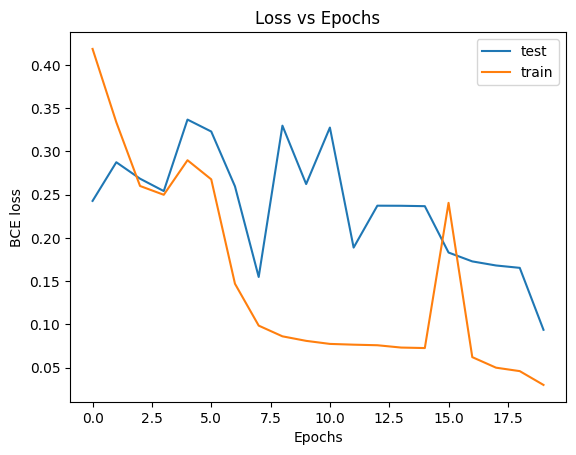

In [23]:

plt.plot(loss_stats['test'],label='test')
plt.plot(loss_stats['train'],label='train')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')

There is likely overfitting, at least the loss of test improves less at the end.

Now I am building a first convolutional network. First loading the data again.  

In [24]:
train_im_loader = DataLoader(dataset=train_im_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_im_loader = DataLoader(dataset=test_im_dataset, batch_size=1)
train_im_loader_pred = DataLoader(dataset=train_im_dataset, batch_size=1)

Now I build the network. 

In [25]:
class CNNBinary3(torch.nn.Module):
    #no padding because image does not really end when the data ends. 
    def __init__(self):
        super(CNNBinary3, self).__init__()
        # L1 ImgIn shape=(?, 11, 11, 1)
        # Conv -> (?, 9, 9, 12)
        # Pool -> (?, 4, 4, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 4, 4, 32)
        # Conv      ->(?, 2, 2, 32)
        # Pool      ->(?, 1, 1, 32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 FC 1x1x32 inputs -> 16 outputs
        self.fc1 = torch.nn.Linear(1 * 1 * 32, 64, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer3 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L4 Final FC 64 inputs -> 1 output
        self.fc2 = torch.nn.Linear(64, 1, bias=True) #
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = torch.sigmoid(self.fc2(out))
        return out

Define the model. 

In [29]:
keep_prob=1
model2 =CNNBinary3()
model2.to(device)
print(model2)

CNNBinary3(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


/tmp/ipykernel_7913/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


In [30]:
#define the function to fit it
#parameters: model used, train_data, test_data, epchs, batch_size, learning_rate, file to collect sats, 
#optional regularization 
def torch_fit(model,train_loader,test_loader,epochs,batch_size,learning_rate,loss_stats,l2reg=0):
    learning_rate = learning_rate
    criterion = torch.nn.BCELoss()    # Softmax is internally computed.
    #if no regularization
    if l2reg==0:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    #l2 regularization is added in optimizer as weight_decay=1e-5 or nsimilar 
    else:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate,weight_decay=l2reg)        
    print("Begin training.")
    for e in tqdm(range(1, epochs+1)):
    
        # TRAINING
        train_epoch_loss = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()
        
            y_train_pred = model(X_train_batch)
        
            train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
            train_loss.backward()
            optimizer.step()
        
            train_epoch_loss += train_loss.item()
        
        
        # VALIDATION    
        with torch.no_grad():
        
            test_epoch_loss = 0
        
            model.eval()
            for X_test_batch, y_test_batch in test_loader:
                X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
                y_test_pred = model(X_test_batch)
                        
                test_loss = criterion(y_test_pred, y_test_batch.unsqueeze(1))
            
                test_epoch_loss += test_loss.item()
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['test'].append(test_epoch_loss/len(test_loader))                              
    
        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Test Loss: {test_epoch_loss/len(test_loader):.5f}')    

Now define the array for data collection and then fit the data. 

In [31]:
#something here wrong but only here, regularized below works 
loss_stats_test = {
    'train': [], 'test': []
}
torch_fit(model2,train_im_loader,test_im_loader,20,64,0.1,loss_stats_test)

Begin training.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 33.93268 | Test Loss: 34.37500
Epoch 002: | Train Loss: 33.93268 | Test Loss: 34.37500
Epoch 003: | Train Loss: 33.93268 | Test Loss: 34.37500
Epoch 004: | Train Loss: 33.93268 | Test Loss: 34.37500
Epoch 005: | Train Loss: 33.99495 | Test Loss: 34.37500
Epoch 006: | Train Loss: 33.95344 | Test Loss: 34.37500
Epoch 007: | Train Loss: 33.95344 | Test Loss: 34.37500
Epoch 008: | Train Loss: 33.99495 | Test Loss: 34.37500
Epoch 009: | Train Loss: 33.95344 | Test Loss: 34.37500
Epoch 010: | Train Loss: 33.95344 | Test Loss: 34.37500
Epoch 011: | Train Loss: 33.97420 | Test Loss: 34.37500
Epoch 012: | Train Loss: 33.93268 | Test Loss: 34.37500
Epoch 013: | Train Loss: 33.89116 | Test Loss: 34.37500
Epoch 014: | Train Loss: 33.91192 | Test Loss: 34.37500
Epoch 015: | Train Loss: 33.97420 | Test Loss: 34.37500
Epoch 016: | Train Loss: 33.93268 | Test Loss: 34.37500
Epoch 017: | Train Loss: 33.91192 | Test Loss: 34.37500
Epoch 018: | Train Loss: 33.91192 | Test Loss: 3

Below I plot both neural network results. 

(0.0, 2.0)

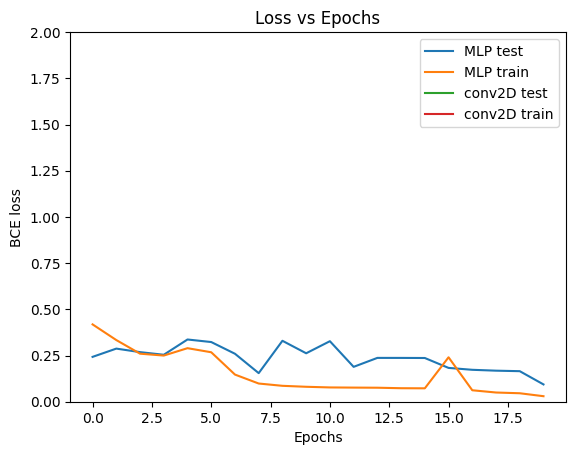

In [32]:
plt.plot(loss_stats['test'],label='MLP test')
plt.plot(loss_stats['train'],label='MLP train')
plt.plot(loss_stats_test['test'],label='conv2D test')
plt.plot(loss_stats_test['train'],label='conv2D train')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')
plt.ylim(0,2)

Convolutional looks better, less overfitting, but it also not look perfect and the final loss is not  the best one. There are wiggles in test seem like that there is overfitting also there. Results change every fit slightly. 

Now I do some other algorithms with standard settings. First xgboost. 

Define function to get confusion matrix. 

In [33]:
def conf_for_torch(predict,target):
    #round prediction
    round_pred=np.round(np.array(predict))
    conf_matrix = confusion_matrix(target, round_pred)
    return conf_matrix

In [34]:
conf_test_m=conf_for_torch(m_test,target_test)
conf_train_m=conf_for_torch(m_train,target_train)
print("3 layer perceptron")
print("train")
print(conf_train_m)
print("test")
print(conf_test_m)

3 layer perceptron
train
[[1109    6]
 [   9 2159]]
test
[[481   3]
 [  9 915]]


Also overfitting. Is better than both before. Number of cases is somewhat low for reliable testing.

Now convolutional network. 

In [37]:
c_test=pred_torch(model2,test_im_loader)
c_train=pred_torch(model2,train_im_loader_pred)
conf_test_c=conf_for_torch(c_test,target_test)
conf_train_c=conf_for_torch(c_train,target_train)
print("2 conv2D layers conv2D one other")
print("train")
print(conf_train_c)
print("test")
print(conf_test_c)

2 conv2D layers conv2D one other
train
[[   0 1115]
 [   0 2168]]
test
[[  0 484]
 [  0 924]]


Even better in test and again overfitting in train. Now I am calculating f1-scores for all. 

In [38]:
print("F1-scores")
print(f"perceptron train {np.round(f1_score(target_train,np.round(m_train)),5)}")
print(f"perceptron test {np.round(f1_score(target_test,np.round(m_test)),5)}")
print(f"conv2d train {np.round(f1_score(target_train,np.round(c_train)),5)}")
print(f"conv2d test {np.round(f1_score(target_test,np.round(c_test)),5)}")

F1-scores
perceptron train 0.99654
perceptron test 0.99349
conv2d train 0.79545
conv2d test 0.79245


All rather good, the differences are small, Convolutional network is best, then perceptron, the xgboost then logistic regression.


Now I do convoltional network with regularization. 

Now I define a function to execute several l2 regularization of the same model after each other

In [39]:
#loop on regularization 
#model used, train set, test set, train set for predict, train_target, test_target
#epochs, batch?size, alpha of fit, list of regularization, optional number of features needed for perceptron 
def run_loop_torch(model,train,test,train_for_pred,train_target,test_target,epochs,batch,alpha,regs,num_features=0):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"running reg of {regs[i]}")
        keep_prob=1
        if num_features==0:
            model3 =model()
        else:
            #num_features partlz needed
            model3 =model(num_features)            
        model3.to(device)
        loss_stats_test3 = {
        'train': [], 'test': []
        }
        torch_fit(model3,train,test,epochs,batch,alpha,loss_stats_test3,l2reg=regs[i])
        test_pred=pred_torch(model3,test)
        train_pred=pred_torch(model3,train_for_pred)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(train_target,np.round(train_pred))
        stats[2,i]=f1_score(test_target,np.round(test_pred))
        stats[3,i]=log_loss(train_target,(train_pred))
        stats[4,i]=log_loss(test_target,(test_pred))   
        print(f"stats of l2reg of  {regs[i]} are {np.round(stats[1:5,i],5)}")
    print(f"full stats are {np.round(stats[:,:].T,5)}")
    return stats

I  now run  convoltional network for several regularization. I choose 200 epochs that convergence is possible when no overfitting occurs. With overfitting is will still change but since the aim here is to find the regularization which has not that problem, it is not a problem. 

Now running best regularizations below. 

In [40]:
num_features=121
keep_prob=1
modelp =BinaryClassification3(num_features)            
modelp.to(device)
loss_stats_test3 = {
        'train': [], 'test': []
        }
torch_fit(modelp,train_loader,test_loader,20,64,0.001,loss_stats_test3,l2reg=0.03)
p2_test_pred=pred_torch(modelp,test_loader)
p2_train_pred=pred_torch(modelp,train_loader_pred)

Begin training.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.37674 | Test Loss: 0.21595
Epoch 002: | Train Loss: 0.30501 | Test Loss: 0.22803
Epoch 003: | Train Loss: 0.30790 | Test Loss: 0.28975
Epoch 004: | Train Loss: 0.20315 | Test Loss: 0.37559
Epoch 005: | Train Loss: 0.16509 | Test Loss: 0.25942
Epoch 006: | Train Loss: 0.10599 | Test Loss: 0.25603
Epoch 007: | Train Loss: 0.13159 | Test Loss: 0.19019
Epoch 008: | Train Loss: 0.10294 | Test Loss: 0.25641
Epoch 009: | Train Loss: 0.09020 | Test Loss: 0.24564
Epoch 010: | Train Loss: 0.11970 | Test Loss: 0.59341
Epoch 011: | Train Loss: 0.26391 | Test Loss: 0.20042
Epoch 012: | Train Loss: 0.16746 | Test Loss: 0.18363
Epoch 013: | Train Loss: 0.08667 | Test Loss: 0.19865
Epoch 014: | Train Loss: 0.07305 | Test Loss: 0.17410
Epoch 015: | Train Loss: 0.09576 | Test Loss: 0.13358
Epoch 016: | Train Loss: 0.06446 | Test Loss: 0.11314
Epoch 017: | Train Loss: 0.08930 | Test Loss: 0.17468
Epoch 018: | Train Loss: 0.09336 | Test Loss: 0.11756
Epoch 019: | Train Loss: 0.1

In [41]:
#slower than perceptron but not much 
keep_prob=1
modelc =CNNBinary3()            
modelc.to(device)
loss_stats_test_c = {
        'train': [], 'test': []
        }
torch_fit(modelc,train_im_loader,test_im_loader,20,64,0.001,loss_stats_test_c,l2reg=0.03)
c2_test_pred=pred_torch(modelc,test_im_loader)
c2_train_pred=pred_torch(modelc,train_im_loader_pred)

Begin training.


/tmp/ipykernel_7913/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.98840 | Test Loss: 0.19716
Epoch 002: | Train Loss: 0.28031 | Test Loss: 0.02844
Epoch 003: | Train Loss: 1.48283 | Test Loss: 0.08422
Epoch 004: | Train Loss: 0.18048 | Test Loss: 0.04607
Epoch 005: | Train Loss: 0.18659 | Test Loss: 0.45790
Epoch 006: | Train Loss: 0.34222 | Test Loss: 0.11361
Epoch 007: | Train Loss: 0.11279 | Test Loss: 0.46837
Epoch 008: | Train Loss: 0.11316 | Test Loss: 0.03552
Epoch 009: | Train Loss: 0.05009 | Test Loss: 0.03041
Epoch 010: | Train Loss: 0.05019 | Test Loss: 0.10142
Epoch 011: | Train Loss: 0.04563 | Test Loss: 0.03802
Epoch 012: | Train Loss: 0.04928 | Test Loss: 0.11071
Epoch 013: | Train Loss: 0.04658 | Test Loss: 0.03994
Epoch 014: | Train Loss: 0.04647 | Test Loss: 0.02880
Epoch 015: | Train Loss: 0.04592 | Test Loss: 0.02580
Epoch 016: | Train Loss: 0.13579 | Test Loss: 0.02948
Epoch 017: | Train Loss: 0.11750 | Test Loss: 0.02461
Epoch 018: | Train Loss: 0.05703 | Test Loss: 0.02992
Epoch 019: | Train Loss: 0.0

Convolutional works better with regularization. 

(0.0, 2.0)

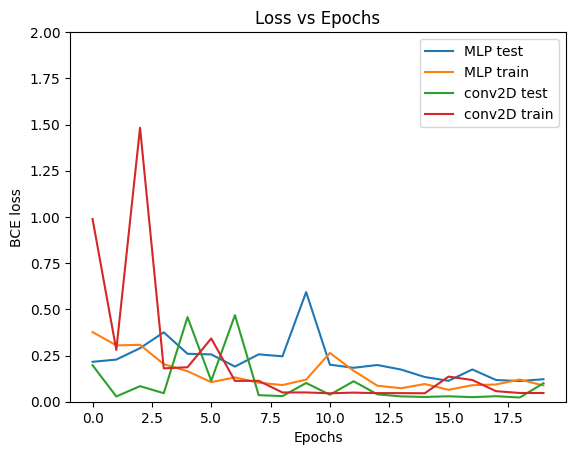

In [44]:
plt.plot(loss_stats_test3['test'],label='MLP test')
plt.plot(loss_stats_test3['train'],label='MLP train')
plt.plot(loss_stats_test_c['test'],label='conv2D test')
plt.plot(loss_stats_test_c['train'],label='conv2D train')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')
plt.ylim(0,2)